In [56]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os

In [57]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [112]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

TARGET_MODULATIONS = [
    'OOK','BPSK', 'QPSK', '8PSK','16QAM','GMSK'
]

BATCH_SIZE = 256 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 100 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = 6 # adjust this to 

# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.2)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 256
  Epochs: 100


In [113]:
print(json.load(open(JSON_PATH, 'r')))

['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [114]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.8, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [115]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str,use_fft: bool = False, seed=48,):
        super(RadioML18Dataset, self).__init__()

        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft 
        try:
            hdf5_file = h5py.File(self.file_path, 'r') #Escaped backslashes 
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except Exception as e: 
            print(f"Error loading file : {e}")
            raise e 
        
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]

        train_proportion=(6*26*nf_train)/self.X.shape[0]
        valid_proportion=(6*26*nf_valid)/self.X.shape[0]
        test_proportion=(6*26*nf_test)/self.X.shape[0]

        self.target_snrs = np.unique(self.Z)

        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )

        # *** CRITICAL FIX: Apply I/Q swap correction for AMC compatibility ***
        print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
 
        self.X_data = self.X_data[:,:,[1,0]]
        print(f"✅ I/Q channels corrected for real-world compatibility")
        if self.use_fft:
            print("Dataset configured to use FFT as input")

        # store statistic of whole dataset (unchanged)
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x_raw,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # convert to tensor adn transpose to (channels and sequence length)
        x = torch.from_numpy(x_raw).float().transpose(0,1)

        if self.use_fft: 
            complex_signal = torch.complex(x[0],x[1])
            fft_result = torch.fft.fft(complex_signal)

            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)

            x = torch.stack([fft_real,fft_imag], dim = 0)
        
        return x,y,z

In [116]:
ds = RadioML18Dataset(mode='test')
data_len = ds.num_data
n_labels=ds.num_lbl
n_snrs = ds.num_snr
frame_size=ds.X.shape[1]

print(data_len)
print(n_labels)
print(n_snrs)
print(frame_size)
del ds

🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
630084
6
26
1024


In [117]:
class SignalAugmentation:
    """
    Comprehensive augmentation suite for I/Q signal processing
    Specifically designed for modulation classification
    """
    
    def __init__(self, config=None):
        # Default augmentation configuration
        self.config = config or {
            'noise_std_range': (0.01, 0.05),           # AWGN noise
            'snr_range': (-10, 30),                     # SNR variation
            'phase_shift_range': (-np.pi, np.pi),      # Phase rotation
            'amplitude_scale_range': (0.7, 1.3),       # Amplitude scaling
            'frequency_shift_range': (-0.1, 0.1),      # Frequency offset
            'time_shift_range': (-50, 50),             # Time shifting
            'iq_imbalance_range': (0.9, 1.1),          # I/Q imbalance
            'dc_offset_range': (-0.1, 0.1),            # DC offset
            'multipath_delay_range': (1, 10),          # Multipath fading
            'dropout_prob_range': (0.0, 0.02),         # Sample dropout
        }
    
    def add_awgn_noise(self, signal, probability=0.8):
        """Add Additive White Gaussian Noise"""
        if torch.rand(1).item() < probability:
            std_min, std_max = self.config['noise_std_range']
            noise_std = torch.empty(1).uniform_(std_min, std_max).item()
            
            # Add complex noise to both I and Q channels
            noise = torch.randn_like(signal) * noise_std
            return signal + noise
        return signal
    
    def snr_variation(self, signal, probability=0.6):
        """Simulate different SNR conditions"""
        if torch.rand(1).item() < probability:
            snr_min, snr_max = self.config['snr_range']
            target_snr_db = torch.empty(1).uniform_(snr_min, snr_max).item()
            
            # Calculate current signal power
            signal_power = torch.mean(signal ** 2)
            
            # Calculate required noise power for target SNR
            snr_linear = 10 ** (target_snr_db / 10)
            noise_power = signal_power / snr_linear
            
            # Add noise
            noise = torch.randn_like(signal) * torch.sqrt(noise_power)
            return signal + noise
        return signal
    
    def phase_rotation(self, signal, probability=0.7):
        """Apply random phase rotation (common in RF systems)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            phase_min, phase_max = self.config['phase_shift_range']
            phase_shift = torch.empty(1).uniform_(phase_min, phase_max).item()
            
            # Apply rotation matrix to I/Q
            cos_phi = np.cos(phase_shift)
            sin_phi = np.sin(phase_shift)
            
            i_rotated = signal[0] * cos_phi - signal[1] * sin_phi
            q_rotated = signal[0] * sin_phi + signal[1] * cos_phi
            
            return torch.stack([i_rotated, q_rotated], dim=0)
        return signal
    
    def amplitude_scaling(self, signal, probability=0.6):
        """Apply random amplitude scaling (AGC effects)"""
        if torch.rand(1).item() < probability:
            scale_min, scale_max = self.config['amplitude_scale_range']
            scale_factor = torch.empty(1).uniform_(scale_min, scale_max).item()
            return signal * scale_factor
        return signal
    
    def frequency_offset(self, signal, probability=0.5):
        """Simulate carrier frequency offset"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            freq_min, freq_max = self.config['frequency_shift_range']
            freq_offset = torch.empty(1).uniform_(freq_min, freq_max).item()
            
            # Create time vector
            seq_len = signal.size(1)
            t = torch.arange(seq_len, dtype=torch.float32) / seq_len
            
            # Apply frequency offset
            complex_offset = torch.exp(1j * 2 * np.pi * freq_offset * t)
            
            # Convert to I/Q and apply
            cos_offset = torch.real(complex_offset)
            sin_offset = torch.imag(complex_offset)
            
            i_shifted = signal[0] * cos_offset - signal[1] * sin_offset
            q_shifted = signal[0] * sin_offset + signal[1] * cos_offset
            
            return torch.stack([i_shifted, q_shifted], dim=0)
        return signal
    
    def time_shifting(self, signal, probability=0.4):
        """Apply random time shifts (timing offset)"""
        if torch.rand(1).item() < probability:
            shift_min, shift_max = self.config['time_shift_range']
            shift = torch.randint(shift_min, shift_max + 1, (1,)).item()
            
            if shift != 0:
                # Circular shift
                return torch.roll(signal, shifts=shift, dims=1)
        return signal
    
    def iq_imbalance(self, signal, probability=0.3):
        """Simulate I/Q imbalance (hardware imperfection)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            imb_min, imb_max = self.config['iq_imbalance_range']
            
            # Different scaling for I and Q channels
            i_scale = torch.empty(1).uniform_(imb_min, imb_max).item()
            q_scale = torch.empty(1).uniform_(imb_min, imb_max).item()
            
            signal_aug = signal.clone()
            signal_aug[0] *= i_scale  # I channel
            signal_aug[1] *= q_scale  # Q channel
            
            return signal_aug
        return signal
    
    def dc_offset(self, signal, probability=0.3):
        """Add DC offset (hardware bias)"""
        if torch.rand(1).item() < probability:
            offset_min, offset_max = self.config['dc_offset_range']
            
            # Different DC offset for each channel
            dc_i = torch.empty(1).uniform_(offset_min, offset_max).item()
            dc_q = torch.empty(1).uniform_(offset_min, offset_max).item()
            
            signal_aug = signal.clone()
            signal_aug[0] += dc_i
            signal_aug[1] += dc_q
            
            return signal_aug
        return signal
    
    def multipath_fading(self, signal, probability=0.2):
        """Simulate simple multipath fading"""
        if torch.rand(1).item() < probability:
            delay_min, delay_max = self.config['multipath_delay_range']
            delay = torch.randint(delay_min, delay_max + 1, (1,)).item()
            
            # Create delayed and attenuated copy
            attenuation = torch.empty(1).uniform_(0.1, 0.4).item()
            delayed_signal = torch.roll(signal, shifts=delay, dims=1) * attenuation
            
            return signal + delayed_signal
        return signal
    
    def sample_dropout(self, signal, probability=0.1):
        """Randomly drop some samples (simulate packet loss)"""
        if torch.rand(1).item() < probability:
            dropout_min, dropout_max = self.config['dropout_prob_range']
            dropout_prob = torch.empty(1).uniform_(dropout_min, dropout_max).item()
            
            # Create dropout mask
            mask = torch.rand(signal.size()) > dropout_prob
            return signal * mask
        return signal
    
    def spectral_inversion(self, signal, probability=0.2):
        """Apply spectral inversion (Q channel sign flip)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            signal_aug = signal.clone()
            signal_aug[1] *= -1  # Flip Q channel
            return signal_aug
        return signal
    
    def __call__(self, signal, augmentation_strength=1.0):
        """
        Apply random combination of augmentations
        
        Args:
            signal: Input I/Q signal tensor (2, seq_len)
            augmentation_strength: Float 0-1, controls how aggressive augmentation is
        """
        
        # Adjust probabilities based on strength
        strength_factor = min(max(augmentation_strength, 0.0), 1.0)
        
        # Apply augmentations in logical order
        augmented = signal.clone()
        
        # Hardware imperfections (apply early)
        augmented = self.dc_offset(augmented, probability=0.3 * strength_factor)
        augmented = self.iq_imbalance(augmented, probability=0.3 * strength_factor)
        
        # Channel effects
        augmented = self.phase_rotation(augmented, probability=0.7 * strength_factor)
        augmented = self.frequency_offset(augmented, probability=0.5 * strength_factor)
        augmented = self.amplitude_scaling(augmented, probability=0.6 * strength_factor)
        
        # Noise and interference
        augmented = self.add_awgn_noise(augmented, probability=0.8 * strength_factor)
        augmented = self.multipath_fading(augmented, probability=0.2 * strength_factor)
        
        # Timing effects
        augmented = self.time_shifting(augmented, probability=0.4 * strength_factor)
        
        # Digital effects
        augmented = self.sample_dropout(augmented, probability=0.1 * strength_factor)
        augmented = self.spectral_inversion(augmented, probability=0.2 * strength_factor)
        
        return augmented

In [118]:
def get_augmentation_presets():
    """
    Get predefined augmentation configurations for different scenarios
    """
    
    presets = {
        'conservative': {
            'noise_std_range': (0.005, 0.02),
            'snr_range': (0, 25),
            'phase_shift_range': (-np.pi/4, np.pi/4),
            'amplitude_scale_range': (0.8, 1.2),
            'frequency_shift_range': (-0.05, 0.05),
            'time_shift_range': (-20, 20),
            'iq_imbalance_range': (0.95, 1.05),
            'dc_offset_range': (-0.05, 0.05),
            'multipath_delay_range': (1, 5),
            'dropout_prob_range': (0.0, 0.01),
        },
        
        'moderate': {
            'noise_std_range': (0.01, 0.05),
            'snr_range': (-5, 30),
            'phase_shift_range': (-np.pi/2, np.pi/2),
            'amplitude_scale_range': (0.7, 1.3),
            'frequency_shift_range': (-0.1, 0.1),
            'time_shift_range': (-50, 50),
            'iq_imbalance_range': (0.9, 1.1),
            'dc_offset_range': (-0.1, 0.1),
            'multipath_delay_range': (1, 10),
            'dropout_prob_range': (0.0, 0.02),
        },
        
        'aggressive': {
            'noise_std_range': (0.02, 0.1),
            'snr_range': (-10, 35),
            'phase_shift_range': (-np.pi, np.pi),
            'amplitude_scale_range': (0.5, 1.5),
            'frequency_shift_range': (-0.2, 0.2),
            'time_shift_range': (-100, 100),
            'iq_imbalance_range': (0.8, 1.2),
            'dc_offset_range': (-0.2, 0.2),
            'multipath_delay_range': (1, 20),
            'dropout_prob_range': (0.0, 0.05),
        }
    }
    
    return presets

In [119]:
class BaseCNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.4, use_residual = True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.block(x)

class BaseCNN_NET(nn.Module):
    def __init__(self, n_labels, dropout_rate=0.4):
        super().__init__()

        self.backbone = nn.Sequential(
            BaseCNN_Block(2, 32, dropout_rate=0.2),
            BaseCNN_Block(32, 64, dropout_rate=0.3),
            BaseCNN_Block(64, 128, dropout_rate=0.3),
            nn.AdaptiveAvgPool1d(16)
        )

        # Enhanced classifier for 19-class problem
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.75),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),

            nn.Linear(128, n_labels)  # This will be 19 for full dataset
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

def create_improved_model(n_labels, dropout_rate=0.4):
    """Create improved CNN model - now works for any number of classes"""
    return BaseCNN_NET(n_labels, dropout_rate)

In [120]:
class CNN32Channels(nn.Module): #32 channels 
    def __init__(self, n_labels=8, dropout_rate=0.4):
        super(CNN32Channels, self).__init__()
       
        # Channel progression: 2 → 16 → 32 → 32 → 24 → 16 → 8
        self.features = nn.Sequential(
            # Block 1: 2 → 16 channels (large kernel for initial feature extraction)
            nn.Conv1d(2, 16, kernel_size=9, stride=2, padding=4),    # 1024 → 512
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 512 → 256
            nn.Dropout(dropout_rate * 0.3),
           
            # Block 2: 16 → 32 channels (max)
            nn.Conv1d(16, 32, kernel_size=7, stride=2, padding=3),   # 256 → 128
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 128 → 64
            nn.Dropout(dropout_rate * 0.4),
           
            # Block 3: 32 → 32 channels (maintain)
            nn.Conv1d(32, 32, kernel_size=5, stride=2, padding=2),   # 64 → 32
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 32 → 16
            nn.Dropout(dropout_rate * 0.4),
           
            # Block 4: 32 → 24 channels (reduce)
            nn.Conv1d(32, 24, kernel_size=3, stride=1, padding=1),   # 16 → 16
            nn.BatchNorm1d(24),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 16 → 8
            nn.Dropout(dropout_rate * 0.5),
           
            # Block 5: 24 → 16 channels
            nn.Conv1d(24, 16, kernel_size=3, stride=1, padding=1),   # 8 → 8
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
           
            # Block 6: 16 → 8 channels (final) - SAFE kernel size
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),    # 8 → 8
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
        )
       
        self.adaptive_pool = nn.AdaptiveAvgPool1d(4)
       
        # Smaller classifier to prevent overfitting
        self.classifier = nn.Sequential(
            nn.Flatten(),
           
            nn.Linear(8 * 4, 128),

            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
           
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),
           
            nn.Linear(64, n_labels)
        )
       
        self._initialize_weights()
   
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
   
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [121]:
class CNN64Channels(nn.Module): # 64 channels 
    def __init__(self, n_labels=8, dropout_rate=0.5):
        super(CNN64Channels, self).__init__()
       
        # Channel progression: 2 → 32 → 64 → 64 → 48 → 32 → 16
        self.features = nn.Sequential(
            # Block 1: 2 → 32 channels
            nn.Conv1d(2, 32, kernel_size=9, stride=2, padding=4),    # 1024 → 512
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 512 → 256
            nn.Dropout(dropout_rate * 0.3),
           
            # Block 2: 32 → 64 channels (max)
            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),   # 256 → 128
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 128 → 64
            nn.Dropout(dropout_rate * 0.4),
           
            # Block 3: 64 → 64 channels (maintain)
            nn.Conv1d(64, 64, kernel_size=5, stride=2, padding=2),   # 64 → 32
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 32 → 16
            nn.Dropout(dropout_rate * 0.5),
           
            # Block 4: 64 → 48 channels (reduce)
            nn.Conv1d(64, 48, kernel_size=3, stride=1, padding=1),   # 16 → 16
            nn.BatchNorm1d(48),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),                   # 16 → 8
            nn.Dropout(dropout_rate * 0.6),
           
            # Block 5: 48 → 32 channels
            nn.Conv1d(48, 32, kernel_size=3, stride=1, padding=1),   # 8 → 8
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
           
            # Block 6: 32 → 16 channels (final)
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1),   # 8 → 8
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
        )
       
        self.adaptive_pool = nn.AdaptiveAvgPool1d(4)
       
        # More robust classifier for higher capacity
        self.classifier = nn.Sequential(
            nn.Flatten(),
           
            nn.Linear(16 * 4, 256),

            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
           
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.8),
           
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
           
            nn.Linear(64, n_labels)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
   
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [122]:
class ComplexCNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.4, use_residual=True):
        super().__init__()
        self.use_residual = use_residual and (in_channels == out_channels)
        
        # More complex block with 3 convolutions instead of 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)  # Additional conv layer
        self.bn3 = nn.BatchNorm1d(out_channels)
        
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Residual connection adjustment
        if self.use_residual:
            self.residual_pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        identity = x
        
        # Three convolution layers instead of two
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = torch.relu(self.bn3(self.conv3(out)))
        
        # Apply pooling
        out = self.pool(out)
        out = self.dropout(out)
        
        # Residual connection
        if self.use_residual:
            identity = self.residual_pool(identity)
            if identity.shape == out.shape:
                out = out + identity
        
        return out

class ComplexCNN_NET(nn.Module):
    def __init__(self, n_labels, dropout_rate=0.4):
        super().__init__()
        
        # Much more complex backbone with more blocks and channels
        self.backbone = nn.Sequential(
            # Block 1: 2 → 32 channels
            ComplexCNN_Block(2, 32, dropout_rate=dropout_rate*0.3, use_residual=False),
            
            # Block 2: 32 → 64 channels  
            ComplexCNN_Block(32, 64, dropout_rate=dropout_rate*0.4, use_residual=True),
            
            # Block 3: 64 → 128 channels
            ComplexCNN_Block(64, 128, dropout_rate=dropout_rate*0.4, use_residual=True),
            
            # Block 4: 128 → 256 channels (NEW - wider network)
            ComplexCNN_Block(128, 256, dropout_rate=dropout_rate*0.5, use_residual=True),
            
            # Block 5: 256 → 256 channels (NEW - maintain high capacity)
            ComplexCNN_Block(256, 256, dropout_rate=dropout_rate*0.5, use_residual=True),
            
            # Block 6: 256 → 128 channels (NEW - gradual reduction)
            ComplexCNN_Block(256, 128, dropout_rate=dropout_rate*0.6, use_residual=False),
            
            # Block 7: 128 → 64 channels (NEW - further reduction)  
            ComplexCNN_Block(128, 64, dropout_rate=dropout_rate*0.6, use_residual=True),
            
            # Adaptive pooling for consistent output
            nn.AdaptiveAvgPool1d(8)  # Smaller output for deeper network
        )

        # More complex classifier with additional layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            # First dense block
            nn.Linear(64 * 8, 1024),  # Much larger first layer
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            # Second dense block  
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.8),

            # Third dense block
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
            
            # Fourth dense block (NEW)
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.4),

            # Final classification layer
            nn.Linear(128, n_labels)
        )
        
        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

def create_complex_model(n_labels, dropout_rate=0.4):
    """Create complex CNN model - same interface as your base model"""
    return ComplexCNN_NET(n_labels, dropout_rate)

In [123]:
from tqdm import trange
from collections import deque

def train_model(model, train_dl, valid_dl, num_epoch=200, device='cuda',
                accumulation_steps=1, use_amp=True, verbose=True):
    # Model-specific learning rates
    learning_rates = {
        'BaseCNN_NET': 2e-3,
        'CNN32Channels': 1e-3,
        'CNN64Channels': 1e-3,
        'ComplexCNN_NET': 5e-4  # Lower for more complex models
    }
   
    # Initialize model and history
    model.to(device)
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
   
    # Get model-specific LR or default to 1e-3
    model_name = model.__class__.__name__
    lr = learning_rates.get(model_name, 1e-3)
   
    # Setup optimization with model-specific LR
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epoch, steps_per_epoch=len(train_dl))
    criterion = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
   
    # Training setup
    best_val_loss = float('inf')
    patience, patience_counter = 25, 0
    output_dir = r"C:\workarea\CNN model\model"
    os.makedirs(output_dir, exist_ok=True)
    best_model_path = os.path.join(output_dir, f'best_{model_name}.pth')  # Model-specific filename

    for epoch in trange(num_epoch, desc=f'Training {model_name}'):
        # Training phase
        model.train()
        total_train_loss, total_train_correct, total_train_samples = 0, 0, 0
        optimizer.zero_grad()
       
        for batch_idx, (x, y, _) in enumerate(train_dl):
            x, y = x.to(device), y.to(device)
           
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
                logits = model(x)
                loss = criterion(logits, y) / accumulation_steps
               
            if use_amp:
                scaler.scale(loss).backward()
            else:
                loss.backward()
               
            if (batch_idx + 1) % accumulation_steps == 0:
                if use_amp:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()
               
            # Update metrics
            total_train_loss += loss.item() * accumulation_steps * x.size(0)
            total_train_correct += (logits.argmax(1) == y).sum().item()
            total_train_samples += x.size(0)
       
        # Validation phase
        model.eval()
        total_val_loss, total_val_correct, total_val_samples = 0, 0, 0
       
        with torch.no_grad():
            for x, y, _ in valid_dl:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                total_val_loss += loss.item() * x.size(0)
                total_val_correct += (logits.argmax(1) == y).sum().item()
                total_val_samples += x.size(0)
       
        # Calculate epoch metrics
        epoch_train_loss = total_train_loss / total_train_samples
        epoch_train_acc = total_train_correct / total_train_samples
        epoch_val_loss = total_val_loss / total_val_samples
        epoch_val_acc = total_val_correct / total_val_samples
       
        # Update history
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
       
        # Checkpointing
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
           
        # Early stopping
        if patience_counter >= patience:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch+1}")
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            break
           
        # Progress reporting (with model-specific LR info)
        if verbose and (epoch % 10 == 0 or epoch == num_epoch - 1):
            current_lr = optimizer.param_groups[0]['lr']
            print(f"{model_name} Epoch {epoch+1}/{num_epoch} | "
                  f"LR: {current_lr:.1e} | "
                  f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc * 100:.2f}% | "
                  f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc * 100:.2f}%")
   
    return model, {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history,
        'best_val_loss': best_val_loss,
        'model_name': model_name,
        'final_lr': optimizer.param_groups[0]['lr']
    }

In [124]:
# ============================================================================
# 3. IMPROVED TESTING AND ANALYSIS FUNCTIONS
# ============================================================================

def test_model_with_improved_plots(model, device='cuda'):
    """
    Enhanced testing function with better memory management and error handling
    """
    model.eval()
    Y_pred_ = []  # Predictions
    Y_true_ = []  # Ground truth
    Z_snr_ = []   # SNR values

    # Use your dataset class
    test_dataset = RadioML18Dataset(mode='test',use_fft=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    target_classes = test_dataset.target_modulations
    target_snrs = test_dataset.target_snrs
    
    # Add debug
    print(f"Target modulations: {target_classes}")
    print(f"Target SNRs: {target_snrs}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Initialize accuracy stats DataFrame
    accuracy_stats = pd.DataFrame(
        0.0,
        index=target_classes,
        columns=target_snrs.astype('str'))

    # Get predictions with tqdm progress bar
    test_progress = tqdm(test_loader, desc="Testing model", leave=True)

    with torch.no_grad():
        for batch_idx, (x, y, z) in enumerate(test_progress):
            # Move tensors to specified device
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)

            # Get model predictions on device
            logits = model(x)
            y_pred = torch.argmax(logits, dim=-1)

            # Store results
            Y_pred_.append(y_pred.cpu())  # Move back to CPU for storage
            Y_true_.append(y.cpu())
            Z_snr_.append(z.cpu())

            # Update progress bar
            if batch_idx % 10 == 0:
                current_acc = (y_pred == y).float().mean().item()
                test_progress.set_postfix({"batch_acc": f"{current_acc:.3f}"})

            # Free up memory
            del x, y, z, logits, y_pred
            if device == 'cuda':
                torch.cuda.empty_cache()

    # Convert to numpy for easier processing
    Y_pred = torch.cat(Y_pred_).numpy()
    Y_true = torch.cat(Y_true_).numpy()
    Z_snr = torch.cat(Z_snr_).numpy()

    # Clear lists to free memory
    del Y_pred_, Y_true_, Z_snr_

    # Calculate overall accuracy
    correct_preds = (Y_pred == Y_true).sum()
    total_samples = len(Y_true)
    total_accuracy = round(correct_preds * 100 / total_samples, 2)
    print(f'Overall test accuracy: {total_accuracy}%')

    # Count samples for each modulation type
    mod_counts = {}
    for mod_idx, mod_name in enumerate(target_classes):
        count = np.sum(Y_true == mod_idx)
        mod_counts[mod_name] = count
        print(f"Modulation {mod_name}: {count} test samples")

    # Calculate accuracy per modulation and SNR with progress bar
    mod_snr_progress = tqdm(list(enumerate(target_classes)),
                           desc="Calculating per-modulation accuracies",
                           leave=True)

    for mod_idx, mod_name in mod_snr_progress:
        mod_snr_progress.set_postfix({"modulation": mod_name})
        for snr_idx, snr in enumerate(target_snrs):
            snr_str = str(snr)

            mask = (Y_true == mod_idx) & (Z_snr == snr)
            total_samples = mask.sum()
            if total_samples > 0:
                correct_samples = ((Y_pred == Y_true) & mask).sum()
                accuracy = (correct_samples * 100 / total_samples)
                accuracy_stats.loc[mod_name, snr_str] = round(accuracy, 2)
            else:
                accuracy_stats.loc[mod_name, snr_str] = np.nan
                print(f"Warning: no samples for {mod_name} at SNR = {snr}")

    return accuracy_stats, mod_counts, Y_true, Y_pred, target_classes

def plot_confusion_matrix(Y_true, Y_pred, target_classes, save_path='C:\\workarea\\CNN model\\result'): #change the path as we want 
    """
    Plot confusion matrix for better understanding of misclassifications
    """
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_classes,
                yticklabels=target_classes)
    plt.title('Confusion Matrix - Signal Modulation Classification')
    plt.xlabel('Predicted Modulation')
    plt.ylabel('True Modulation')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_classes))

def plot_improved_test_accuracy(model, device='cuda', save_path='C:\\workarea\\CNN model\\result'):#change the path as we want 
    """
    Enhanced plotting function with confusion matrix and better analysis
    """
    accuracy_df, mod_counts, Y_true, Y_pred, target_classes = test_model_with_improved_plots(model, device)
    
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # 1. Plot confusion matrix first
    plot_confusion_matrix(Y_true, Y_pred, target_classes, save_path)

    # 2. Overall accuracy vs SNR plot
    plt.figure(figsize=(14, 8))

    accuracy_long = accuracy_df.reset_index().melt(
        id_vars=['index'],
        var_name='SNR',
        value_name='Accuracy'
    )
    accuracy_long.columns = ['Modulation', 'SNR', 'Accuracy']

    # Convert SNR to numeric for proper ordering
    accuracy_long['SNR_numeric'] = accuracy_long['SNR'].astype(int)
    accuracy_long = accuracy_long.sort_values('SNR_numeric')

    sns.lineplot(
        data=accuracy_long,
        x='SNR_numeric',
        y='Accuracy',
        hue='Modulation',
        marker='o',
        markersize=8,
        linewidth=2
    )

    # Highlight PSK modulations
    psk_mods = [mod for mod in accuracy_df.index if 'PSK' in mod]
    if psk_mods:
        print(f"Highlighting PSK modulations: {psk_mods}")
        for mod in psk_mods:
            mod_data = accuracy_long[accuracy_long['Modulation'] == mod]
            if not mod_data.empty:
                plt.plot(mod_data['SNR_numeric'], mod_data['Accuracy'],
                         linewidth=4,
                         linestyle='--',
                         marker='*',
                         markersize=12,
                         alpha=0.8)

    plt.title('Classification Accuracy vs SNR for Different Modulation Types', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{save_path}all_modulations_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Enhanced heatmap visualization
    plt.figure(figsize=(16, 8))

    # Reorder columns (SNRs) numerically
    snr_columns = sorted(accuracy_df.columns, key=int)
    accuracy_df_sorted = accuracy_df[snr_columns]

    # Create heatmap with better formatting
    mask = accuracy_df_sorted.isna()
    sns.heatmap(accuracy_df_sorted.astype(float),
                annot=True,
                cmap='RdYlGn',
                fmt='.1f',
                mask=mask,
                cbar_kws={'label': 'Accuracy (%)'},
                linewidths=0.5)

    plt.title('Classification Accuracy Heatmap by Modulation and SNR', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Modulation Type', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{save_path}modulation_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Summary statistics
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)

    overall_acc = np.nanmean(accuracy_df_sorted.values)
    print(f"Overall average accuracy: {overall_acc:.2f}%")

    # Best and worst performing modulations
    mod_avg_acc = accuracy_df_sorted.mean(axis=1).sort_values(ascending=False)
    print(f"\nBest performing modulation: {mod_avg_acc.index[0]} ({mod_avg_acc.iloc[0]:.2f}%)")
    print(f"Worst performing modulation: {mod_avg_acc.index[-1]} ({mod_avg_acc.iloc[-1]:.2f}%)")

    return accuracy_df_sorted

def plot_training_history(model_name, history, save_path='C:\\workarea\\CNN model\\result'): #change the path as we want 
    """
    Enhanced training history plotting with more details
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, [acc * 100 for acc in history['train_acc']], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, [acc * 100 for acc in history['val_acc']], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Overfitting analysis
    train_val_gap = [abs(t - v) * 100 for t, v in zip(history['train_acc'], history['val_acc'])]
    ax3.plot(epochs, train_val_gap, 'g-', linewidth=2)
    ax3.set_title('Train-Validation Gap (Overfitting Indicator)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy Gap (%)')
    ax3.grid(True, alpha=0.3)

    # Show validation loss trend
    ax4.plot(epochs, history['val_loss'], 'purple', linewidth=2)
    ax4.set_title('Validation Loss Trend')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Loss')
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'Training Analysis: {model_name}', fontsize=16)
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}{model_name}_detailed_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print training summary
    print(f"\nTraining Summary for {model_name}:")
    print(f"Epochs trained: {len(epochs)}")
    print(f"Final training accuracy: {history['train_acc'][-1]*100:.2f}%")
    print(f"Final validation accuracy: {history['val_acc'][-1]*100:.2f}%")
    print(f"Best validation loss: {history['best_val_loss']:.4f}")

def check_dataset_distribution(dataset_mode='test'):
    """
    Enhanced dataset analysis with better statistics
    """
    # Create dataset for analysis
    dataset = RadioML18Dataset(mode=dataset_mode)

    # Analyze distribution
    mod_counts = {}
    snr_mod_counts = {}

    # Initialize counts for all modulations
    for mod in dataset.target_modulations:
        mod_counts[mod] = 0

    # Set up progress bar
    progress_bar = tqdm(range(len(dataset)), desc=f"Analyzing {dataset_mode} dataset", leave=True)

    # Count occurrences of each modulation
    for i in progress_bar:
        _, mod_idx, snr = dataset[i]
        mod = dataset.target_modulations[mod_idx]

        # Count by modulation
        mod_counts[mod] += 1

        # Count by modulation and SNR
        if snr not in snr_mod_counts:
            snr_mod_counts[snr] = {}
        if mod not in snr_mod_counts[snr]:
            snr_mod_counts[snr][mod] = 0
        snr_mod_counts[snr][mod] += 1

        # Update progress bar less frequently for performance
        if i % 1000 == 0:
            progress_bar.set_postfix({"current_mod": mod, "snr": snr})

    print(f"\n{dataset_mode.upper()} Dataset Distribution Analysis:")
    print("="*50)
    total_samples = sum(mod_counts.values())
    print(f"Total samples: {total_samples:,}")

    print("\nModulation distribution:")
    for mod, count in mod_counts.items():
        percentage = (count / total_samples) * 100
        print(f"  {mod}: {count:,} samples ({percentage:.1f}%)")

    # Check if dataset is balanced
    counts = list(mod_counts.values())
    is_balanced = max(counts) - min(counts) == 0
    print(f"\nDataset balance: {'Perfectly balanced' if is_balanced else 'Imbalanced'}")

    return mod_counts, snr_mod_counts

# Main execution function
def improved_train_test_plots(model, model_name, device='cuda', num_epoch=NUM_EPOCHS):
    """
    Complete training and testing pipeline with enhanced analysis
    """
    print("="*60)
    print(f"TRAINING AND EVALUATION PIPELINE: {model_name}")
    print("="*60)

    # First check the dataset distribution
    print("\n1. Analyzing dataset distribution...")
    mod_counts, snr_mod_counts = check_dataset_distribution('test')

    # Create data loaders using your configuration
    train_dataset = RadioML18Dataset(mode='train',use_fft=True)
    valid_dataset = RadioML18Dataset(mode='valid',use_fft=True)
    
    train_dl = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    valid_dl = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # Train the model using your train_model function
    print(f"\n2. Training {model_name}...")
    model, train_history = train_model(model, train_dl, valid_dl, num_epoch=num_epoch, device=device)

    # Define save paths
    output_dir = r"C:\\workarea\\CNN model\\model"
    os.makedirs(output_dir, exist_ok=True)

    # Save the trained model
    state_dict_path = os.path.join(output_dir, f"{model_name}_state_dict.pth")
    full_model_path = os.path.join(output_dir, f"{model_name}_full_model.pth")

    torch.save(model.state_dict(), state_dict_path)
    torch.save(model, full_model_path)

    print(f"Model saved as:\n  - {state_dict_path}\n  - {full_model_path}")

    # Plot training history
    print("\n3. Plotting training history...")
    plot_training_history(model_name, train_history)

    # Test and analyze the model
    print("\n4. Testing model and generating analysis...")
    accuracy_results = plot_improved_test_accuracy(model, device)

    print("\n5. Analysis complete!")
    print("="*60)

    return model, train_history, accuracy_results

In [125]:
def train_model_with_augmentation(model, train_dataset, valid_dataset,
                                 augmentation_preset = 'moderate',
                                 num_epoch = 100,
                                 batch_size = 256, device = 'cuda'):
    """
    Processes dataset through preprocessing -> augmentation -> model training
    WITHOUT performance optimizations
    
    Parameters:
    model - Model to train
    train_dataset - Training RadioML18Dataset instance
    valid_dataset - Validation RadioML18Dataset instance  
    augmentation_preset - 'conservative', 'moderate', or 'aggressive'
    num_epoch - Number of training epochs
    batch_size - Batch size for training
    device - Device to train on
    
    Returns:
    Trained model object
    """

    presets = get_augmentation_presets()
    aug_config = presets[augmentation_preset] 
    augmentor = SignalAugmentation(config = aug_config) 
    
    # create a custom collate fucntion for augmentation 
    def augment_collate_fn(batch): 
        x_batch,y_batch,z_batch = [], [], []
        for x,y,z in batch: 
            x_aug = augmentor(x, augmentation_strength = 0.8)  # apply the augmentation 
            x_batch.append(x_aug)
            y_batch.append(y)
            z_batch.append(z) 
        #stack it into sensor 
        x_tensor = torch.stack(x_batch)
        y_tensor = torch.tensor(y_batch, dtype = torch.long)
        z_tensor = torch.tensor(z_batch, dtype = torch.float32) 

        return x_tensor,y_tensor,z_tensor
    # Standard collate function for validation (no augmentation)
    def standard_collate_fn(batch): 
        x_batch,y_batch,z_batch = [], [], [] 

        for x,y,z in batch: 
            x_batch.append(x) 
            y_batch.append(y)
            z_batch.append(z)
            
        x_tensor = torch.stack(x_batch)
        y_tensor = torch.tensor(y_batch, dtype = torch.long)
        z_tensor = torch.tensor(z_batch, dtype = torch.float32) 

        return x_tensor,y_tensor,z_tensor
        
    # create dataloader 
    train_loader = DataLoader(
        dataset = train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        drop_last = True, 
        collate_fn = augment_collate_fn,
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        collate_fn=standard_collate_fn,       
    )

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-3, weight_decay = 5e-5)
    criterion = nn.CrossEntropyLoss()

    print(f"Training with {augmentation_preset} augmentation....")

    for epoch in range(num_epoch): 

        model.train()
        train_loss = 0.0 
        train_correct = 0 
        train_total = 0 

        for batch_idx, (x,y,z) in enumerate(train_loader): 

            x = x.to(device) 
            y = y.to(device)

            # Forward pass 
            optimizer.zero_grad() 
            outputs = model(x) 
            loss = criterion(outputs,y) 

            # backward pass 
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0) 
            _, predicted = outputs.max(1) 
            train_total += y.size(0)
            train_correct += predicted.eq(y).sum().item()

        # Validation phase 
        model.eval()
        val_loss = 0.0 
        val_correct = 0 
        val_total = 0 

        with torch.no_grad(): 
              for x, y, z in valid_loader:
                x = x.to(device)
                y = y.to(device)
                
                outputs = model(x)
                loss = criterion(outputs, y)
                
                val_loss += loss.item() * x.size(0)
                _, predicted = outputs.max(1)
                val_total += y.size(0)
                val_correct += predicted.eq(y).sum().item()
        
        # Calculate epoch metrics
        avg_train_loss = train_loss / train_total
        train_acc = 100. * train_correct / train_total
        avg_val_loss = val_loss / val_total
        val_acc = 100. * val_correct / val_total
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}] '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    print("Training completed!")
    return model          
            

In [126]:
model =BaseCNN_NET(INPUT_CHANNELS).to('cuda')

# Safer: create explicit dummy input
dummy_input = torch.randn(1, INPUT_CHANNELS,SEQUENCE_LENGTH).to('cuda')

summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
BaseCNN_NET                              [1, 2]                    --
├─Sequential: 1-1                        [1, 128, 16]              --
│    └─BaseCNN_Block: 2-1                [1, 32, 512]              --
│    │    └─Sequential: 3-1              [1, 32, 512]              3,456
│    └─BaseCNN_Block: 2-2                [1, 64, 256]              --
│    │    └─Sequential: 3-2              [1, 64, 256]              18,816
│    └─BaseCNN_Block: 2-3                [1, 128, 128]             --
│    │    └─Sequential: 3-3              [1, 128, 128]             74,496
│    └─AdaptiveAvgPool1d: 2-4            [1, 128, 16]              --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Flatten: 2-5                      [1, 2048]                 --
│    └─Linear: 2-6                       [1, 512]                  1,049,088
│    └─BatchNorm1d: 2-7                  [1, 512]                  

In [127]:
model =CNN32Channels(INPUT_CHANNELS).to('cuda')

# Safer: create explicit dummy input
dummy_input = torch.randn(1, INPUT_CHANNELS,SEQUENCE_LENGTH).to('cuda')

summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CNN32Channels                            [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 8]                 --
│    └─Conv1d: 2-1                       [1, 16, 512]              304
│    └─BatchNorm1d: 2-2                  [1, 16, 512]              32
│    └─ReLU: 2-3                         [1, 16, 512]              --
│    └─AvgPool1d: 2-4                    [1, 16, 256]              --
│    └─Dropout: 2-5                      [1, 16, 256]              --
│    └─Conv1d: 2-6                       [1, 32, 128]              3,616
│    └─BatchNorm1d: 2-7                  [1, 32, 128]              64
│    └─ReLU: 2-8                         [1, 32, 128]              --
│    └─AvgPool1d: 2-9                    [1, 32, 64]               --
│    └─Dropout: 2-10                     [1, 32, 64]               --
│    └─Conv1d: 2-11                      [1, 32, 32]               5,152
│    └─B

In [128]:
model =CNN64Channels(INPUT_CHANNELS).to('cuda')

# Safer: create explicit dummy input
dummy_input = torch.randn(1, INPUT_CHANNELS,SEQUENCE_LENGTH).to('cuda')

summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CNN64Channels                            [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 8]                --
│    └─Conv1d: 2-1                       [1, 32, 512]              608
│    └─BatchNorm1d: 2-2                  [1, 32, 512]              64
│    └─ReLU: 2-3                         [1, 32, 512]              --
│    └─AvgPool1d: 2-4                    [1, 32, 256]              --
│    └─Dropout: 2-5                      [1, 32, 256]              --
│    └─Conv1d: 2-6                       [1, 64, 128]              14,400
│    └─BatchNorm1d: 2-7                  [1, 64, 128]              128
│    └─ReLU: 2-8                         [1, 64, 128]              --
│    └─AvgPool1d: 2-9                    [1, 64, 64]               --
│    └─Dropout: 2-10                     [1, 64, 64]               --
│    └─Conv1d: 2-11                      [1, 64, 32]               20,544
│    

In [129]:
model =ComplexCNN_NET(INPUT_CHANNELS).to('cuda')

# Safer: create explicit dummy input
dummy_input = torch.randn(1, INPUT_CHANNELS,SEQUENCE_LENGTH).to('cuda')

summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
ComplexCNN_NET                           [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 8]                --
│    └─ComplexCNN_Block: 2-1             [1, 32, 512]              --
│    │    └─Conv1d: 3-1                  [1, 32, 1024]             224
│    │    └─BatchNorm1d: 3-2             [1, 32, 1024]             64
│    │    └─Conv1d: 3-3                  [1, 32, 1024]             3,104
│    │    └─BatchNorm1d: 3-4             [1, 32, 1024]             64
│    │    └─Conv1d: 3-5                  [1, 32, 1024]             3,104
│    │    └─BatchNorm1d: 3-6             [1, 32, 1024]             64
│    │    └─MaxPool1d: 3-7               [1, 32, 512]              --
│    │    └─Dropout: 3-8                 [1, 32, 512]              --
│    └─ComplexCNN_Block: 2-2             [1, 64, 256]              --
│    │    └─Conv1d: 3-9                  [1, 64, 512]              6,208
│    

TRAINING AND EVALUATION PIPELINE: BaseCNN_NET

1. Analyzing dataset distribution...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility


Analyzing test dataset: 100%|██████████| 630084/630084 [00:02<00:00, 290328.52it/s, current_mod=GMSK, snr=30]  



TEST Dataset Distribution Analysis:
Total samples: 630,084

Modulation distribution:
  OOK: 105,014 samples (16.7%)
  BPSK: 105,014 samples (16.7%)
  QPSK: 105,014 samples (16.7%)
  8PSK: 105,014 samples (16.7%)
  16QAM: 105,014 samples (16.7%)
  GMSK: 105,014 samples (16.7%)

Dataset balance: Perfectly balanced
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input


C:\Users\N208\AppData\Local\Temp\ipykernel_14456\1989102584.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


🔧 Applying I/Q swap fix to valid dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input

2. Training BaseCNN_NET...


Training BaseCNN_NET:   1%|          | 1/100 [00:00<01:06,  1.49it/s]

BaseCNN_NET Epoch 1/100 | LR: 8.0e-05 | Train Loss: 1.7878 Acc: 19.47% | Val Loss: 1.7890 Acc: 16.47%


Training BaseCNN_NET:  11%|█         | 11/100 [00:05<00:43,  2.04it/s]

BaseCNN_NET Epoch 11/100 | LR: 8.0e-05 | Train Loss: 1.4943 Acc: 29.46% | Val Loss: 1.5617 Acc: 28.30%


Training BaseCNN_NET:  21%|██        | 21/100 [00:10<00:38,  2.06it/s]

BaseCNN_NET Epoch 21/100 | LR: 8.0e-05 | Train Loss: 1.4618 Acc: 31.42% | Val Loss: 1.5773 Acc: 27.76%


Training BaseCNN_NET:  31%|███       | 31/100 [00:15<00:33,  2.05it/s]

BaseCNN_NET Epoch 31/100 | LR: 8.0e-05 | Train Loss: 1.4326 Acc: 34.69% | Val Loss: 1.6382 Acc: 28.40%


Training BaseCNN_NET:  32%|███▏      | 32/100 [00:16<00:34,  1.96it/s]


Early stopping at epoch 33
Model saved as:
  - C:\\workarea\\CNN model\\model\BaseCNN_NET_state_dict.pth
  - C:\\workarea\\CNN model\\model\BaseCNN_NET_full_model.pth

3. Plotting training history...


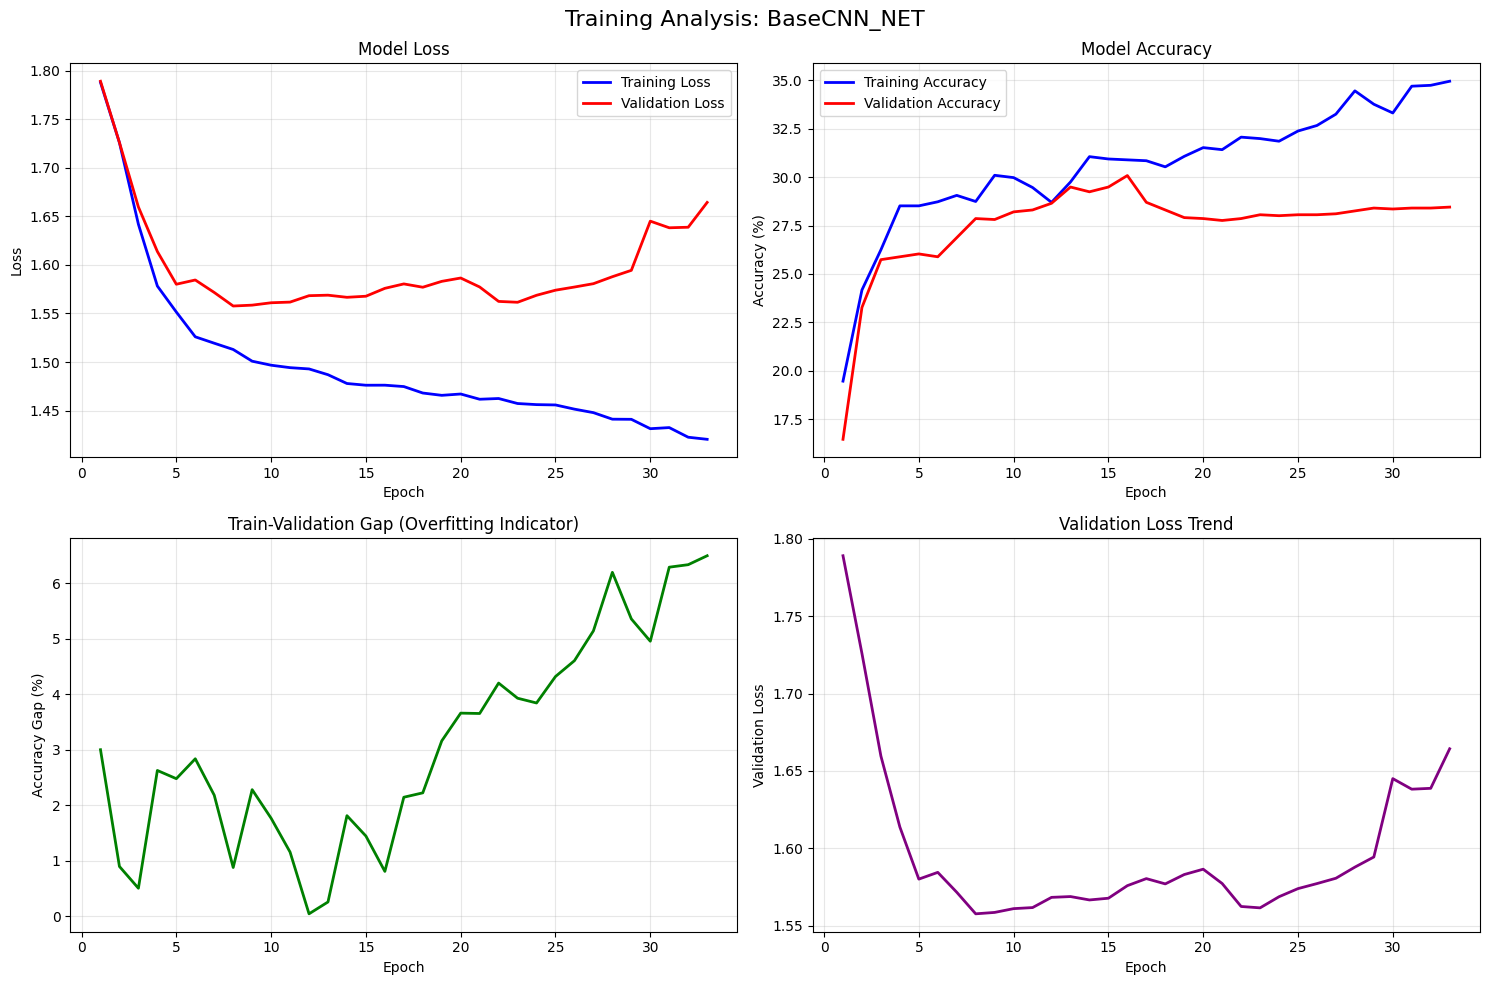


Training Summary for BaseCNN_NET:
Epochs trained: 33
Final training accuracy: 34.95%
Final validation accuracy: 28.45%
Best validation loss: 1.5577

4. Testing model and generating analysis...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input
Target modulations: ['OOK', 'BPSK', 'QPSK', '8PSK', '16QAM', 'GMSK']
Target SNRs: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Test dataset size: 630084


Testing model: 100%|██████████| 2462/2462 [00:33<00:00, 74.54it/s, batch_acc=0.422]


Overall test accuracy: 28.13%
Modulation OOK: 105014 test samples
Modulation BPSK: 105014 test samples
Modulation QPSK: 105014 test samples
Modulation 8PSK: 105014 test samples
Modulation 16QAM: 105014 test samples
Modulation GMSK: 105014 test samples


Calculating per-modulation accuracies: 100%|██████████| 6/6 [00:00<00:00, 35.71it/s, modulation=GMSK] 


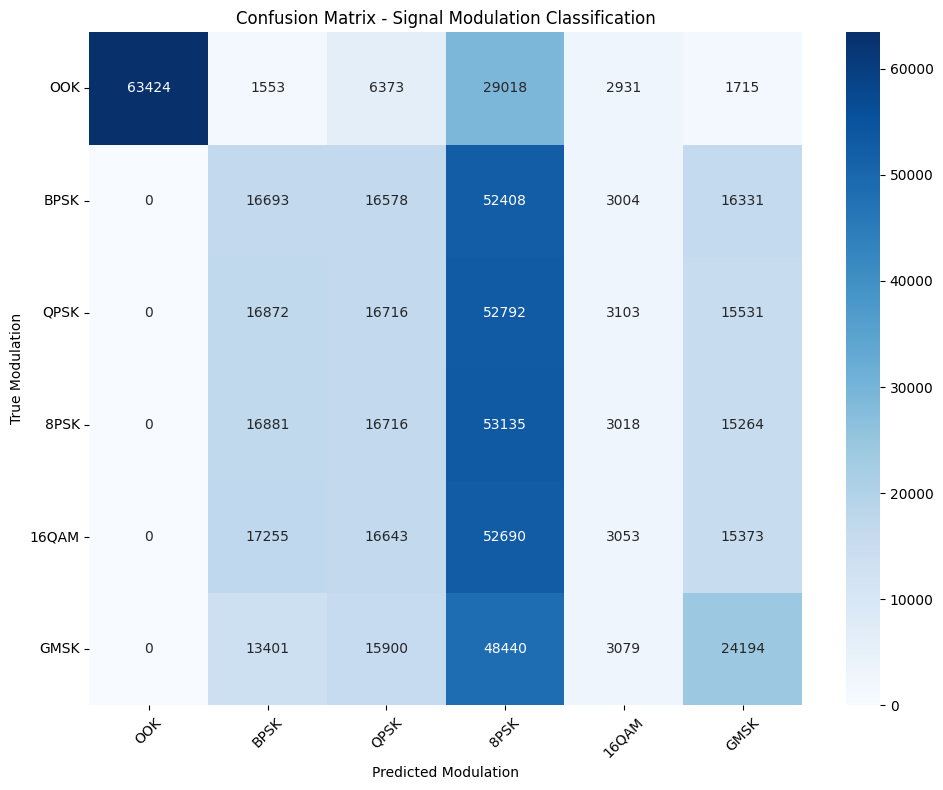


Detailed Classification Report:
              precision    recall  f1-score   support

         OOK       1.00      0.60      0.75    105014
        BPSK       0.20      0.16      0.18    105014
        QPSK       0.19      0.16      0.17    105014
        8PSK       0.18      0.51      0.27    105014
       16QAM       0.17      0.03      0.05    105014
        GMSK       0.27      0.23      0.25    105014

    accuracy                           0.28    630084
   macro avg       0.34      0.28      0.28    630084
weighted avg       0.34      0.28      0.28    630084

Highlighting PSK modulations: ['BPSK', 'QPSK', '8PSK']


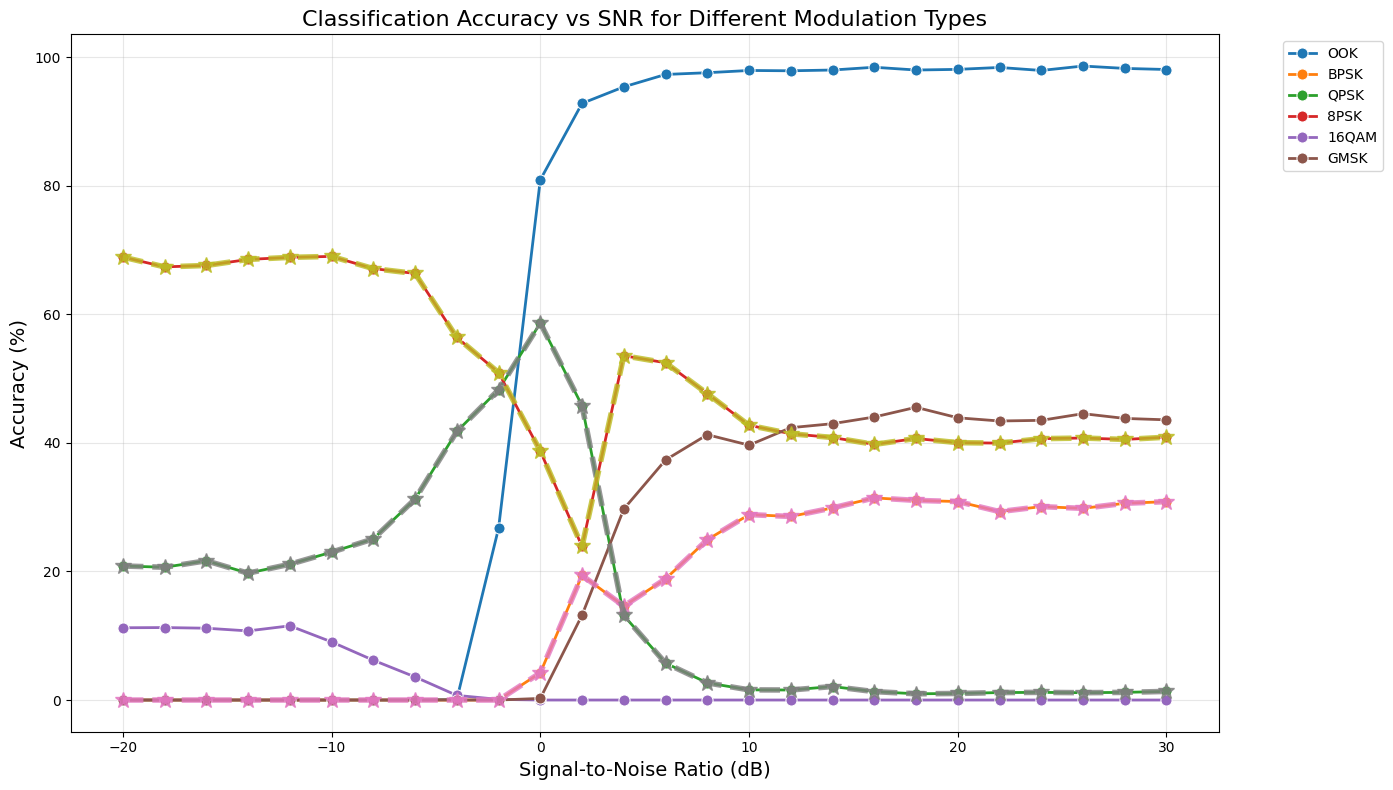

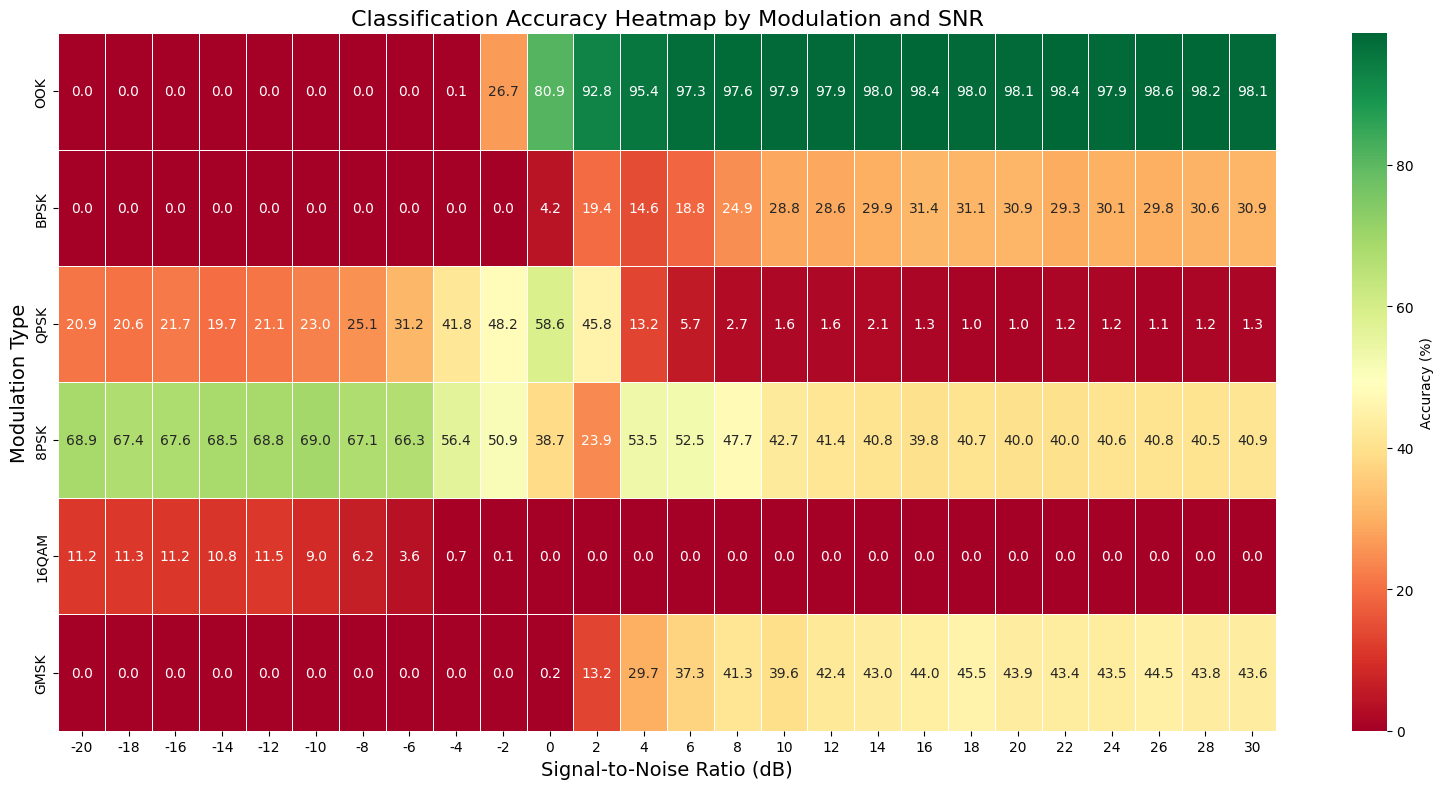


PERFORMANCE SUMMARY
Overall average accuracy: 28.13%

Best performing modulation: OOK (60.39%)
Worst performing modulation: 16QAM (2.91%)

5. Analysis complete!


(BaseCNN_NET(
   (backbone): Sequential(
     (0): BaseCNN_Block(
       (block): Sequential(
         (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
         (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (5): ReLU(inplace=True)
         (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (7): Dropout(p=0.2, inplace=False)
       )
     )
     (1): BaseCNN_Block(
       (block): Sequential(
         (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
         (4): BatchNorm1d(64

In [130]:
improved_train_test_plots(
    model=BaseCNN_NET(n_labels = NUM_CLASSES),
    model_name='BaseCNN_NET',
    device='cuda',
    num_epoch = 100
)

TRAINING AND EVALUATION PIPELINE: CNN32Channels

1. Analyzing dataset distribution...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility


Analyzing test dataset: 100%|██████████| 733278/733278 [00:02<00:00, 304398.94it/s, current_mod=16QAM, snr=30] 



TEST Dataset Distribution Analysis:
Total samples: 733,278

Modulation distribution:
  OOK: 104,754 samples (14.3%)
  4ASK: 104,754 samples (14.3%)
  8ASK: 104,754 samples (14.3%)
  BPSK: 104,754 samples (14.3%)
  QPSK: 104,754 samples (14.3%)
  8PSK: 104,754 samples (14.3%)
  16QAM: 104,754 samples (14.3%)

Dataset balance: Perfectly balanced
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility


C:\Users\N208\AppData\Local\Temp\ipykernel_14456\1989102584.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


🔧 Applying I/Q swap fix to valid dataset...
✅ I/Q channels corrected for real-world compatibility

2. Training CNN32Channels...


Training CNN32Channels:   1%|          | 1/100 [00:00<00:42,  2.34it/s]

CNN32Channels Epoch 1/100 | LR: 4.0e-05 | Train Loss: 2.2787 Acc: 15.00% | Val Loss: 1.9812 Acc: 14.87%


Training CNN32Channels:  11%|█         | 11/100 [00:03<00:24,  3.60it/s]

CNN32Channels Epoch 11/100 | LR: 4.0e-05 | Train Loss: 1.9507 Acc: 20.78% | Val Loss: 1.8138 Acc: 21.61%


Training CNN32Channels:  21%|██        | 21/100 [00:05<00:19,  3.96it/s]

CNN32Channels Epoch 21/100 | LR: 4.0e-05 | Train Loss: 1.8408 Acc: 22.88% | Val Loss: 1.7435 Acc: 24.43%


Training CNN32Channels:  31%|███       | 31/100 [00:08<00:17,  3.88it/s]

CNN32Channels Epoch 31/100 | LR: 4.0e-05 | Train Loss: 1.7625 Acc: 24.77% | Val Loss: 1.6906 Acc: 27.18%


Training CNN32Channels:  41%|████      | 41/100 [00:11<00:15,  3.81it/s]

CNN32Channels Epoch 41/100 | LR: 4.0e-05 | Train Loss: 1.7205 Acc: 25.36% | Val Loss: 1.6298 Acc: 28.94%


Training CNN32Channels:  51%|█████     | 51/100 [00:13<00:14,  3.49it/s]

CNN32Channels Epoch 51/100 | LR: 4.0e-05 | Train Loss: 1.6725 Acc: 25.71% | Val Loss: 1.5857 Acc: 30.22%


Training CNN32Channels:  61%|██████    | 61/100 [00:16<00:10,  3.71it/s]

CNN32Channels Epoch 61/100 | LR: 4.0e-05 | Train Loss: 1.6238 Acc: 27.08% | Val Loss: 1.5427 Acc: 30.70%


Training CNN32Channels:  71%|███████   | 71/100 [00:19<00:08,  3.44it/s]

CNN32Channels Epoch 71/100 | LR: 4.0e-05 | Train Loss: 1.5884 Acc: 27.86% | Val Loss: 1.5135 Acc: 31.03%


Training CNN32Channels:  81%|████████  | 81/100 [00:21<00:05,  3.65it/s]

CNN32Channels Epoch 81/100 | LR: 4.0e-05 | Train Loss: 1.5597 Acc: 29.50% | Val Loss: 1.4935 Acc: 31.03%


Training CNN32Channels:  91%|█████████ | 91/100 [00:24<00:02,  4.13it/s]

CNN32Channels Epoch 91/100 | LR: 4.0e-05 | Train Loss: 1.5323 Acc: 29.76% | Val Loss: 1.4697 Acc: 31.72%


Training CNN32Channels: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]

CNN32Channels Epoch 100/100 | LR: 4.0e-05 | Train Loss: 1.5025 Acc: 30.83% | Val Loss: 1.4589 Acc: 31.94%
Model saved as:
  - C:\\workarea\\CNN model\\model\CNN32Channels_state_dict.pth
  - C:\\workarea\\CNN model\\model\CNN32Channels_full_model.pth

3. Plotting training history...


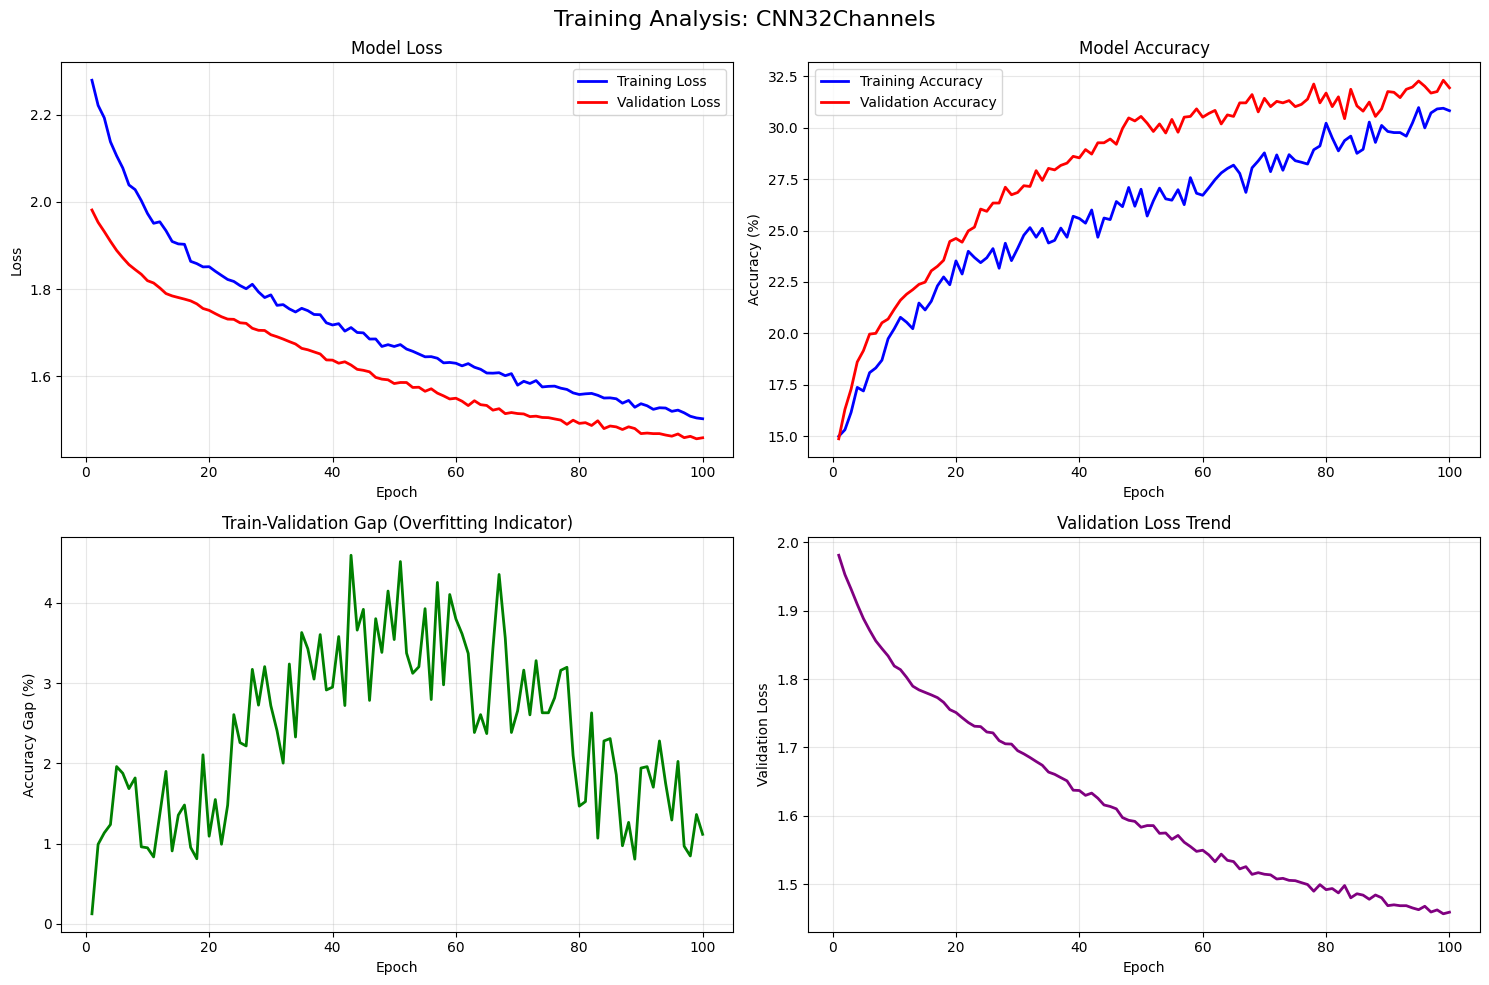


Training Summary for CNN32Channels:
Epochs trained: 100
Final training accuracy: 30.83%
Final validation accuracy: 31.94%
Best validation loss: 1.4565

4. Testing model and generating analysis...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
Target modulations: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16QAM']
Target SNRs: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Test dataset size: 733278


Testing model: 100%|██████████| 2865/2865 [00:08<00:00, 325.28it/s, batch_acc=0.000]


Overall test accuracy: 32.71%
Modulation OOK: 104754 test samples
Modulation 4ASK: 104754 test samples
Modulation 8ASK: 104754 test samples
Modulation BPSK: 104754 test samples
Modulation QPSK: 104754 test samples
Modulation 8PSK: 104754 test samples
Modulation 16QAM: 104754 test samples


Calculating per-modulation accuracies: 100%|██████████| 7/7 [00:00<00:00, 28.57it/s, modulation=16QAM]


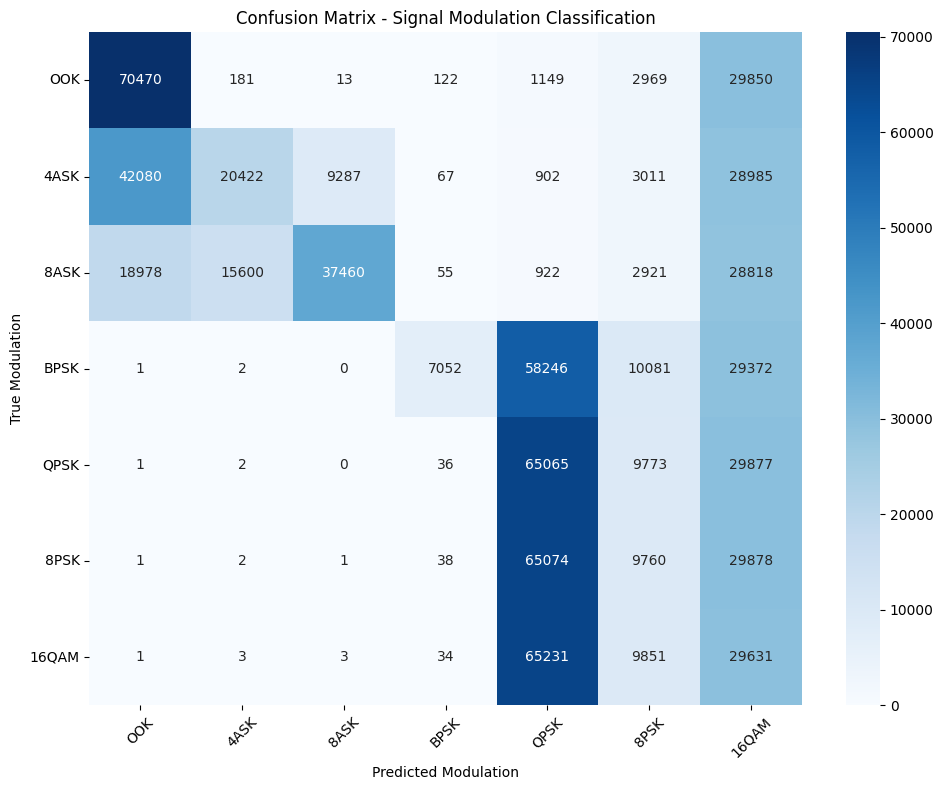


Detailed Classification Report:
              precision    recall  f1-score   support

         OOK       0.54      0.67      0.60    104754
        4ASK       0.56      0.19      0.29    104754
        8ASK       0.80      0.36      0.49    104754
        BPSK       0.95      0.07      0.13    104754
        QPSK       0.25      0.62      0.36    104754
        8PSK       0.20      0.09      0.13    104754
       16QAM       0.14      0.28      0.19    104754

    accuracy                           0.33    733278
   macro avg       0.49      0.33      0.31    733278
weighted avg       0.49      0.33      0.31    733278

Highlighting PSK modulations: ['BPSK', 'QPSK', '8PSK']


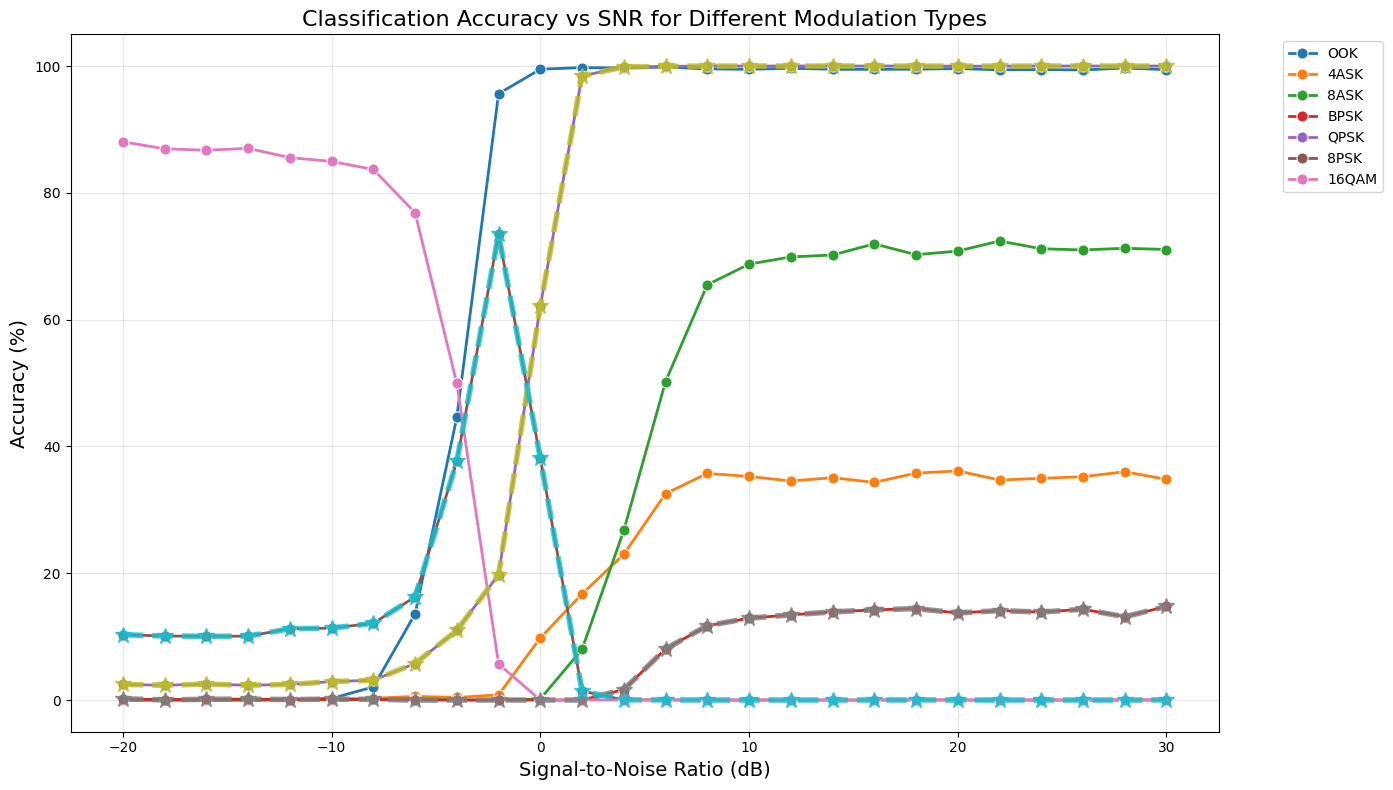

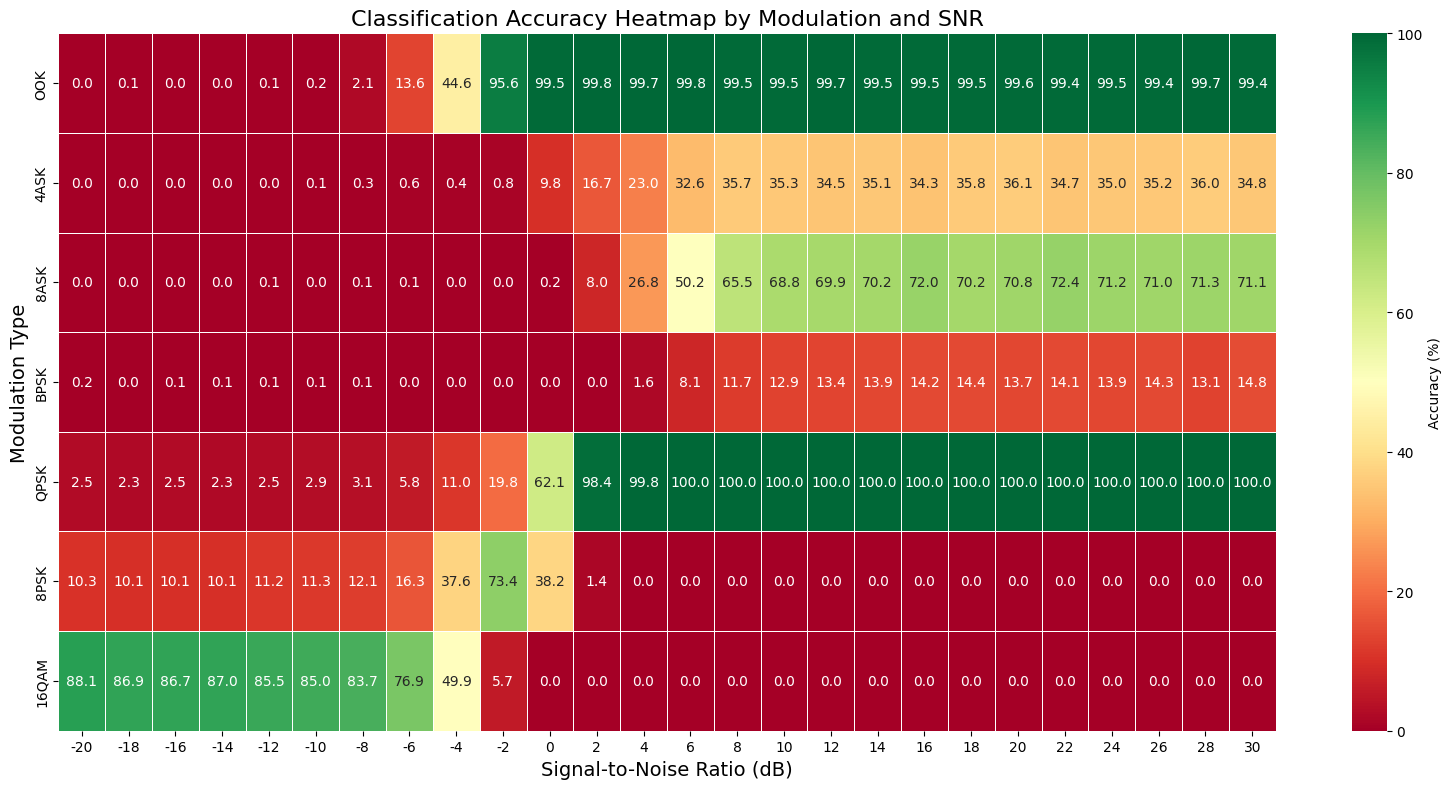


PERFORMANCE SUMMARY
Overall average accuracy: 32.71%

Best performing modulation: OOK (67.27%)
Worst performing modulation: BPSK (6.73%)

5. Analysis complete!


(CNN32Channels(
   (features): Sequential(
     (0): Conv1d(2, 16, kernel_size=(9,), stride=(2,), padding=(4,))
     (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (4): Dropout(p=0.12, inplace=False)
     (5): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,))
     (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): ReLU(inplace=True)
     (8): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (9): Dropout(p=0.16000000000000003, inplace=False)
     (10): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
     (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU(inplace=True)
     (13): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
     (14): Dropout(p=0.16000000000000003, inplace=False)
     (15): Conv1d(32, 24, kernel_size=

In [103]:
improved_train_test_plots(
    model=CNN32Channels(n_labels = NUM_CLASSES),
    model_name='CNN32Channels',
    device='cuda',
    num_epoch = 100
)

In [ ]:
improved_train_test_plots(
    model=CNN64Channels(n_labels = NUM_CLASSES),
    model_name='CNN64Channels',
    device='cuda',
    num_epoch = 100
)

TRAINING AND EVALUATION PIPELINE: ComplexCNN_NET

1. Analyzing dataset distribution...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility


Analyzing test dataset: 100%|██████████| 630084/630084 [00:02<00:00, 300409.83it/s, current_mod=GMSK, snr=30]  



TEST Dataset Distribution Analysis:
Total samples: 630,084

Modulation distribution:
  OOK: 105,014 samples (16.7%)
  BPSK: 105,014 samples (16.7%)
  QPSK: 105,014 samples (16.7%)
  8PSK: 105,014 samples (16.7%)
  16QAM: 105,014 samples (16.7%)
  GMSK: 105,014 samples (16.7%)

Dataset balance: Perfectly balanced
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input


C:\Users\N208\AppData\Local\Temp\ipykernel_14456\1989102584.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


🔧 Applying I/Q swap fix to valid dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input

2. Training ComplexCNN_NET...


Training ComplexCNN_NET:   1%|          | 1/100 [00:00<01:36,  1.02it/s]

ComplexCNN_NET Epoch 1/100 | LR: 2.0e-05 | Train Loss: 2.2430 Acc: 17.52% | Val Loss: 1.8434 Acc: 16.91%


Training ComplexCNN_NET:  11%|█         | 11/100 [00:09<01:11,  1.25it/s]

ComplexCNN_NET Epoch 11/100 | LR: 2.0e-05 | Train Loss: 1.9880 Acc: 20.75% | Val Loss: 1.8502 Acc: 17.31%


Training ComplexCNN_NET:  21%|██        | 21/100 [00:17<01:04,  1.22it/s]

ComplexCNN_NET Epoch 21/100 | LR: 2.0e-05 | Train Loss: 1.7562 Acc: 24.13% | Val Loss: 1.7140 Acc: 23.42%


Training ComplexCNN_NET:  31%|███       | 31/100 [00:25<00:57,  1.21it/s]

ComplexCNN_NET Epoch 31/100 | LR: 2.0e-05 | Train Loss: 1.6620 Acc: 25.57% | Val Loss: 1.6275 Acc: 26.53%


Training ComplexCNN_NET:  41%|████      | 41/100 [00:33<00:49,  1.19it/s]

ComplexCNN_NET Epoch 41/100 | LR: 2.0e-05 | Train Loss: 1.6107 Acc: 27.01% | Val Loss: 1.5997 Acc: 26.82%


Training ComplexCNN_NET:  51%|█████     | 51/100 [00:42<00:40,  1.20it/s]

ComplexCNN_NET Epoch 51/100 | LR: 2.0e-05 | Train Loss: 1.5864 Acc: 26.67% | Val Loss: 1.5863 Acc: 27.12%


Training ComplexCNN_NET:  61%|██████    | 61/100 [00:50<00:32,  1.19it/s]

ComplexCNN_NET Epoch 61/100 | LR: 2.0e-05 | Train Loss: 1.5666 Acc: 27.54% | Val Loss: 1.5736 Acc: 27.17%


Training ComplexCNN_NET:  71%|███████   | 71/100 [00:58<00:24,  1.21it/s]

ComplexCNN_NET Epoch 71/100 | LR: 2.0e-05 | Train Loss: 1.5541 Acc: 27.33% | Val Loss: 1.5619 Acc: 27.22%


Training ComplexCNN_NET:  81%|████████  | 81/100 [01:06<00:14,  1.28it/s]

ComplexCNN_NET Epoch 81/100 | LR: 2.0e-05 | Train Loss: 1.5429 Acc: 27.55% | Val Loss: 1.5493 Acc: 27.37%


Training ComplexCNN_NET:  91%|█████████ | 91/100 [01:14<00:07,  1.28it/s]

ComplexCNN_NET Epoch 91/100 | LR: 2.0e-05 | Train Loss: 1.5346 Acc: 28.52% | Val Loss: 1.5390 Acc: 27.61%


Training ComplexCNN_NET: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

ComplexCNN_NET Epoch 100/100 | LR: 2.0e-05 | Train Loss: 1.5300 Acc: 27.78% | Val Loss: 1.5358 Acc: 27.17%
Model saved as:
  - C:\\workarea\\CNN model\\model\ComplexCNN_NET_state_dict.pth
  - C:\\workarea\\CNN model\\model\ComplexCNN_NET_full_model.pth

3. Plotting training history...


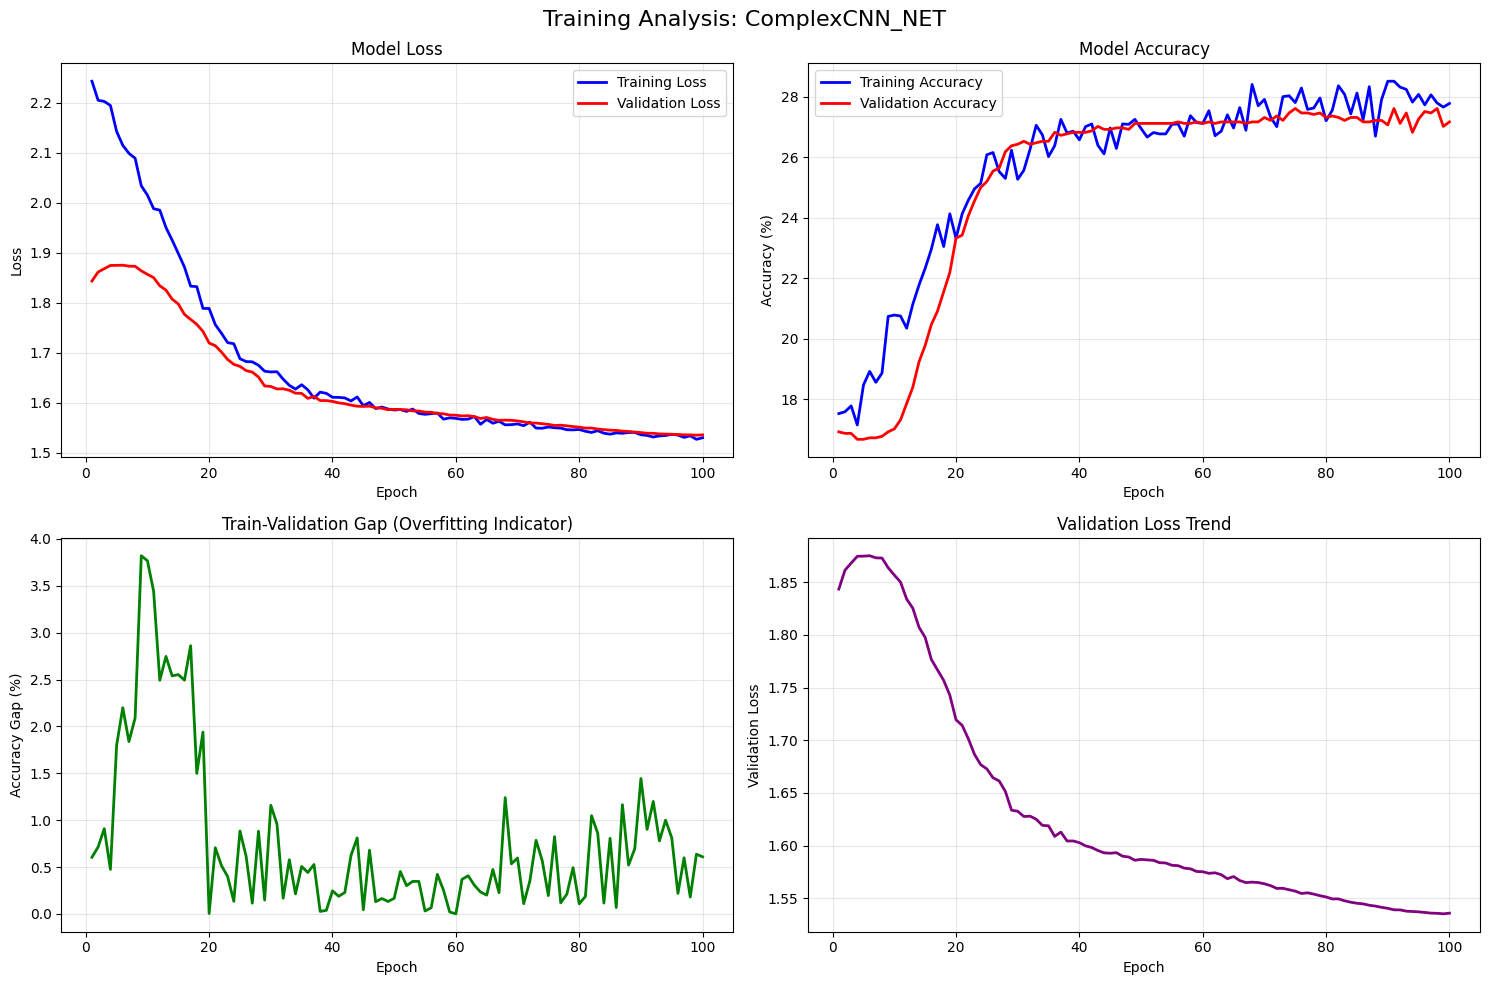


Training Summary for ComplexCNN_NET:
Epochs trained: 100
Final training accuracy: 27.78%
Final validation accuracy: 27.17%
Best validation loss: 1.5351

4. Testing model and generating analysis...
🔧 Applying I/Q swap fix to test dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input
Target modulations: ['OOK', 'BPSK', 'QPSK', '8PSK', '16QAM', 'GMSK']
Target SNRs: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Test dataset size: 630084


Testing model: 100%|██████████| 2462/2462 [00:44<00:00, 54.87it/s, batch_acc=0.000]


Overall test accuracy: 27.67%
Modulation OOK: 105014 test samples
Modulation BPSK: 105014 test samples
Modulation QPSK: 105014 test samples
Modulation 8PSK: 105014 test samples
Modulation 16QAM: 105014 test samples
Modulation GMSK: 105014 test samples


Calculating per-modulation accuracies: 100%|██████████| 6/6 [00:00<00:00, 33.86it/s, modulation=GMSK] 


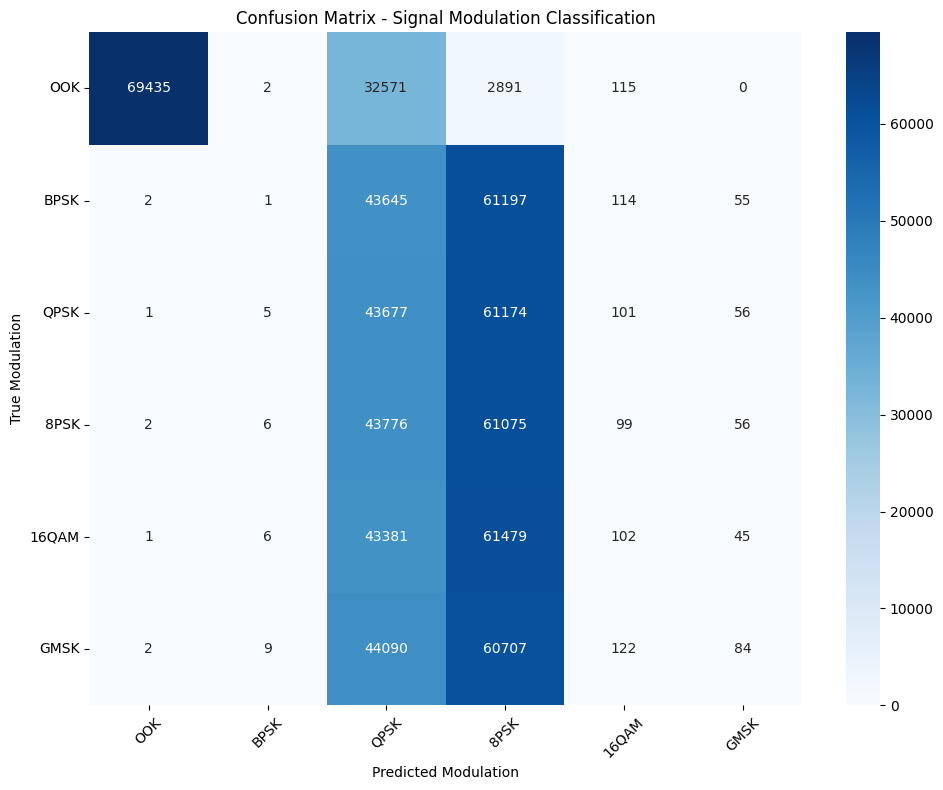


Detailed Classification Report:
              precision    recall  f1-score   support

         OOK       1.00      0.66      0.80    105014
        BPSK       0.03      0.00      0.00    105014
        QPSK       0.17      0.42      0.25    105014
        8PSK       0.20      0.58      0.30    105014
       16QAM       0.16      0.00      0.00    105014
        GMSK       0.28      0.00      0.00    105014

    accuracy                           0.28    630084
   macro avg       0.31      0.28      0.22    630084
weighted avg       0.31      0.28      0.22    630084

Highlighting PSK modulations: ['BPSK', 'QPSK', '8PSK']


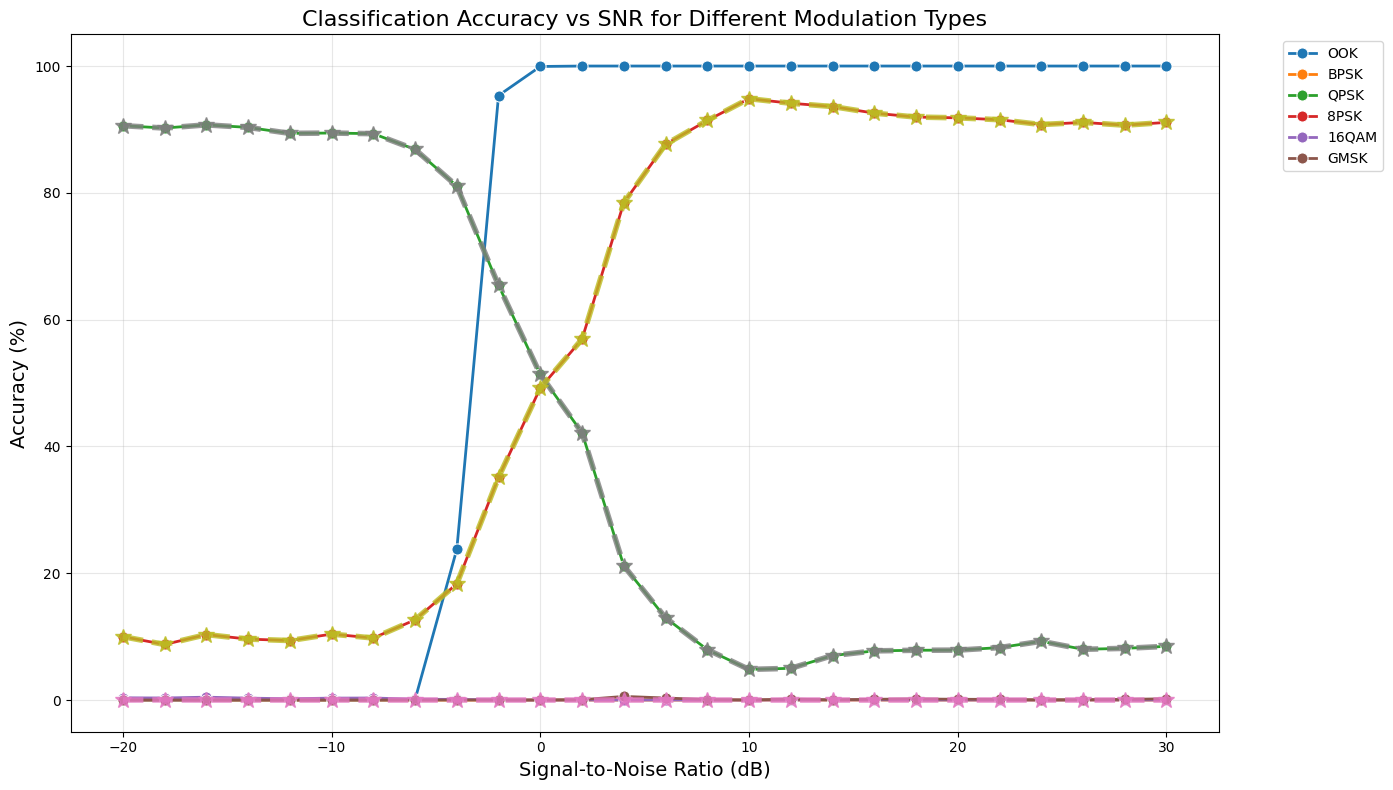

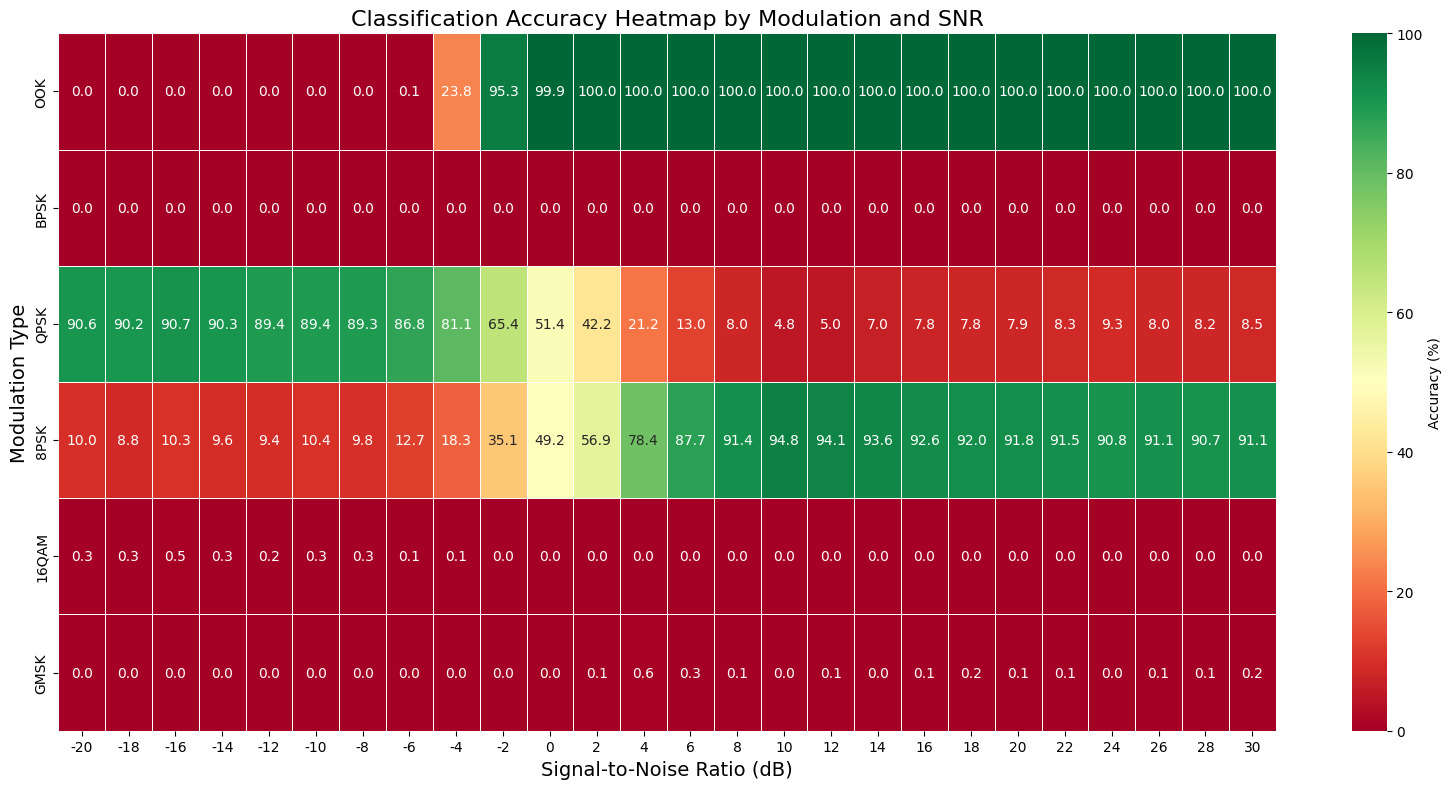


PERFORMANCE SUMMARY
Overall average accuracy: 27.67%

Best performing modulation: OOK (66.12%)
Worst performing modulation: BPSK (0.00%)

5. Analysis complete!


(ComplexCNN_NET(
   (backbone): Sequential(
     (0): ComplexCNN_Block(
       (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
       (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
       (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
       (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (dropout): Dropout(p=0.12, inplace=False)
     )
     (1): ComplexCNN_Block(
       (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
       (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))

In [131]:
improved_train_test_plots(
    model=ComplexCNN_NET(n_labels = NUM_CLASSES),
    model_name='ComplexCNN_NET',
    device='cuda',
    num_epoch = 100
)

In [ ]:
# Create datasets
train_dataset = RadioML18Dataset(mode='train')
valid_dataset = RadioML18Dataset(mode='valid')

# Create model
model = BaseCNN_NET(n_labels=NUM_CLASSES)

# Train with augmentation
trained_model = train_model_with_augmentation(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    augmentation_preset='moderate',  # 'conservative', 'moderate', or 'aggressive'
    num_epoch=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

In [ ]:
# Then test it manually
accuracy_results = plot_improved_test_accuracy(trained_model, device)

In [ ]:
# Create datasets
train_dataset = RadioML18Dataset(mode='train')
valid_dataset = RadioML18Dataset(mode='valid')

# Create model
model2 = CNN32Channels(n_labels=NUM_CLASSES)

# Train with augmentation
trained_model2 = train_model_with_augmentation(
    model=model2,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    augmentation_preset='moderate',  # 'conservative', 'moderate', or 'aggressive'
    num_epoch=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

In [ ]:
# Then test it manually
accuracy_results2 = plot_improved_test_accuracy(trained_model2, device)

In [ ]:
# Create datasets
train_dataset = RadioML18Dataset(mode='train')
valid_dataset = RadioML18Dataset(mode='valid')

# Create model
model3 = CNN64Channels(n_labels=NUM_CLASSES)

# Train with augmentation
trained_model3 = train_model_with_augmentation(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    augmentation_preset='moderate',  # 'conservative', 'moderate', or 'aggressive'
    num_epoch=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

In [ ]:
# Then test it manually
accuracy_results3 = plot_improved_test_accuracy(trained_model3, device)

In [ ]:
# Create datasets
train_dataset = RadioML18Dataset(mode='train')
valid_dataset = RadioML18Dataset(mode='valid')

# Create model
model4 = ComplexCNN_NET(n_labels=NUM_CLASSES)

# Train with augmentation
trained_model3 = train_model_with_augmentation(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    augmentation_preset='moderate',  # 'conservative', 'moderate', or 'aggressive'
    num_epoch=200,
    batch_size=BATCH_SIZE,
    device=device
)

In [ ]:
# Then test it manually
accuracy_results3 = plot_improved_test_accuracy(trained_model3, device)